Import libraries and load data

In [1]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv("datasets/cookie_cats.csv")

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Distribution of the number of game rounds players played during their first 2 weeks playing the game

Text(0, 0.5, '# User')

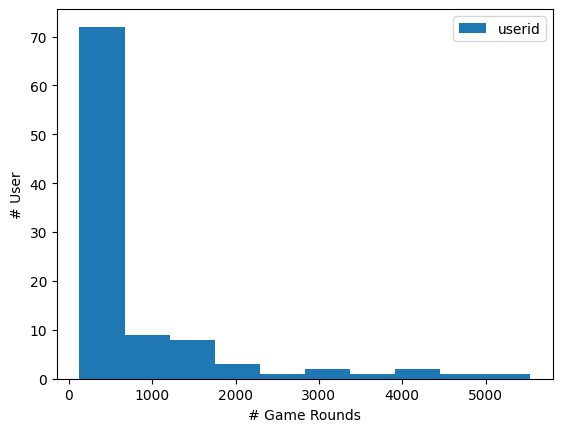

In [3]:
# Import matplotlib
import matplotlib.pyplot as plt

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds').agg({'userid':'count'})

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(kind='hist')
ax.set_xlabel("# Game Rounds")
ax.set_ylabel("# User")

### AB test allocation 

In [4]:
# Counting the number of players in each AB group.
df.groupby('version').agg({'userid':'count'})

,userid
version,
gate_30,44700
gate_40,45489


### 1 day retention

#### Overall 1-day retention

In [5]:
# The % of users that came back the day after they installed
df['retention_1'].sum()

40153

#### 1 day retention by test allocation

In [6]:
# 1 day retention in each AB group.
df.groupby('version').agg({'userid':'count','retention_1':'sum'})

,userid,retention_1
version,,
gate_30,44700,20034
gate_40,45489,20119


#### Percent retention on day 1 after installing by version
**44.8% in the control group (gate_30) and 44.2% in the treatment group (gate_40)**

<p> In plain number, moving the gate to level 40 results in decreased 1-day retention. To be certain with these difference, use bootstrapping to look how uncertain the retention numbers are.</p>

<AxesSubplot: ylabel='Density'>

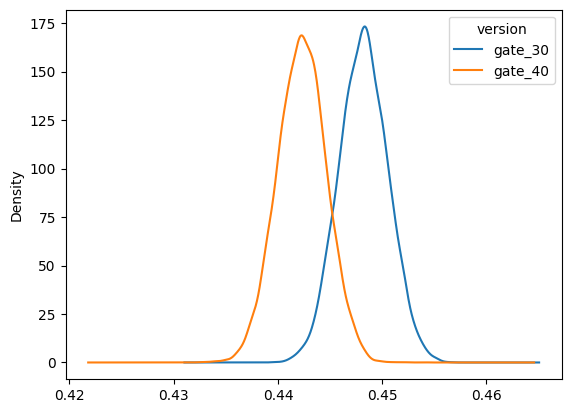

In [9]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(10000):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

<p>The two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. We should also look at the difference in 1-day retention</p>

Text(0.5, 0, 'Pct difference (%)')

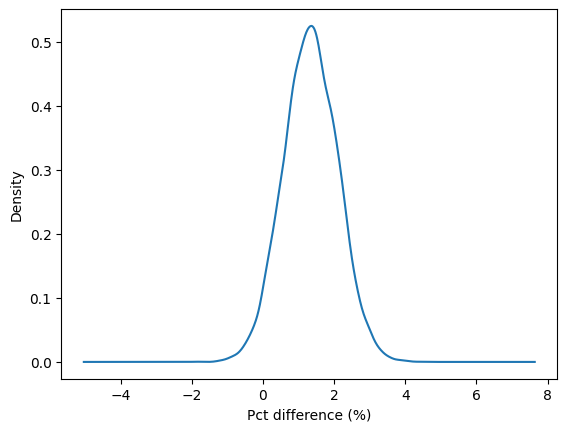

In [10]:
# Creating a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] *100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='kde')
ax.set_xlabel('Pct difference (%)')

The most likely % difference is around 1% until 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. Next,  we should calculate the probability that the difference is above 0

In [11]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
# boot_1d['diff'] is a series of number
prob = (boot_1d['diff']>0.0).sum()/len(boot_1d['diff'])

# Probability difference in > 0 (in favor of gate_30)
'{:.1%}'.format(prob)

'96.4%'

### 7 day retention
<p>The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>

<p>Next, calculate 7-day retention for the two AB-groups.</p>

In [12]:
# Calculating 7-day retention for both AB-groups
df.groupby('version').agg({'userid':'count','retention_7':'sum'})

,userid,retention_7
version,,
gate_30,44700,8502
gate_40,45489,8279


**Percentage of 7 day retention is 19.02% for the control group (gate_30) and 18.20% for the tretment group (gate_40).**

<p> Like the 1 day retention, gate_40 showed lower retention, and the difference between the two groups is even higher than that in the 1 day retention. Next, use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

'453.1%'

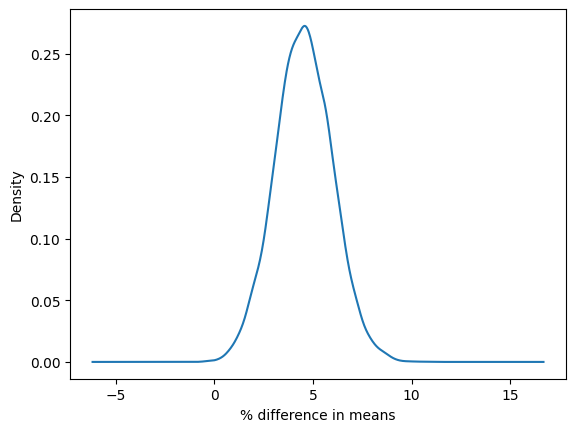

In [13]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(10000):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] *100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = boot_7d['diff'].mean()

# Printing the probability
'{:.1%}'.format(prob)

### Conclusion
<p>The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. 